Prepare and analyze the cosine similarity results

In [376]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import save_npz, load_npz
import matplotlib.pyplot as plt

In [377]:
# What to do with this? Generate examples for all!

# Look at examples, what is our cos sim threshold?
# Remove where both are -1? and both are 0?
# Which codes appear most often?
# Which codes appear most often when agreement?
# Which codes appear most often in disagreement?
# Look at sentences that are exactly the same: how often is there disagreement?
# What changes if we limit to combinations by different coders/from different documents?
# in 0/-1 codes: how often do coders agree, that there is no meaning in this?

In [378]:
# load the sparse matrix with the extreme similarity values:
cs_sparse = load_npz('data/cos_sim_output_08_mpnet.npz')

# also load the full corpus df, so that we can add create a df with q_sentences, information and their similarity score for extreme values
corpus_df_full = pd.read_csv("data/english_annotated_full_df.csv")

In [379]:
cs_sparse

<202187x202187 sparse matrix of type '<class 'numpy.float32'>'
	with 379546 stored elements in Compressed Sparse Row format>

In [380]:
# convert the sparse matrix into a useful df:
cs_sparse = coo_matrix(cs_sparse)
data = {
    'index_x': cs_sparse.row,
    'index_y': cs_sparse.col,
    'cosine_similarity': cs_sparse.data
}
cosine_sim_df = pd.DataFrame(data)

In [381]:
cosine_sim_df.head(2)

,index_x,index_y,cosine_similarity
0,7,9,0.851987
1,7,119,0.903366


In [382]:
cosine_sim_df.shape

(379546, 3)

In [383]:
corpus_df = corpus_df_full[['q_sentence', 'main_codes', 'coderid', 'manifesto_id', 'party', 'date',
        'title', 'countryname', 'partyname', 'RILE']]

In [384]:
# append the columns from the corpus_df, so that we get the info for both quasi sentences
cosine_sim_df = pd.merge(cosine_sim_df, corpus_df, left_on='index_x', right_index=True, how='left')
cosine_sim_df = pd.merge(cosine_sim_df, corpus_df, left_on='index_y', right_index=True, how='left')

In [385]:
cosine_sim_df.head(3)

,index_x,index_y,cosine_similarity,q_sentence_x,main_codes_x,coderid_x,manifesto_id_x,party_x,date_x,title_x,...,q_sentence_y,main_codes_y,coderid_y,manifesto_id_y,party_y,date_y,title_y,countryname_y,partyname_y,RILE_y
0,7,9,0.851987,Our first priority is to:,-1,102,51421_199705,51421,199705,Make the Difference,...,Key priorities are to:,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0
1,7,119,0.903366,Our first priority is to:,-1,102,51421_199705,51421,199705,Make the Difference,...,Our priorities are to:,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0
2,7,215,0.903366,Our first priority is to:,-1,102,51421_199705,51421,199705,Make the Difference,...,Our priorities are to:,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0


In [386]:
# How many values do we have that are below -0.8?
cosine_sim_df[cosine_sim_df["cosine_similarity"] < 0].shape
# --> none of them!

(0, 23)

In [387]:
cosine_sim_df.shape

(379546, 23)

In [396]:
# How often do coders agree that similar sentences have no content/useful meaning? So how often do both give 0 or -1? How often does only one give 0 or -1?

# How often does either -1 or 0 appear in one or both of the codes:
count_a = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) | (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# How often do both codes have either -1 or 0:
count_b = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) & (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# How often does only one code have either -1 or 0:
count_c = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) ^ (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# So, how often do coders disagree on these?
print(count_c/count_a)

0.09033440319222762


--> In about 91% of the time, coders agree if there is no meaning in a q_sentence. 9% of the time, one of them sees a meaning!

In [369]:
# Remove all rows where both codes are -1; here the coders agree that it is not a topic that needs to be coded, likely just formating etc.
#cosine_sim_df = cosine_sim_df[(cosine_sim_df['main_codes_x'] != -1) | (cosine_sim_df['main_codes_y'] != -1)]
# same thing for both codes 0
#cosine_sim_df = cosine_sim_df[(cosine_sim_df['main_codes_x'] != 0) | (cosine_sim_df['main_codes_y'] != 0)]


# and now also where one is -1 and one is 0: the coders agree, there is no meaning in this

# This does it all in one: removes all rows where both codes are either 0 or -1:
cosine_sim_df = cosine_sim_df[~(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) & (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))]


cosine_sim_df.shape

(127867, 23)

Looking at the lowest cosine similarities. Are they good enough?

In [215]:
# Set display options to show full contents of each column
pd.set_option('display.max_colwidth', None)
# reverse with:
# pd.reset_option('display.max_colwidth')

In [216]:
cosine_sim_df.sort_values(by="cosine_similarity",
                          ascending=True)[["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y", "cosine_similarity"]].head(20)

,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,cosine_similarity
19423,Give higher priority to the physical healthcare of those with mental health problems.,504,Prioritising mental healthcare,0,0.800000
233298,and generate more local investment.,411,and stimulate their local economy.,409,0.800000
19646,End exploitative zero-hours contracts.,701,banning exploitative zero-hours contracts,412,0.800002
248096,Reducing unnecessary regulation.,703,Cut red tape and improved regulations,-1,0.800003
172041,"every Australian has the right to access good quality health care, housing and income support.",503,"Reasonable access to quality, affordable health care and education for all Australians, regardless of their location and personal circumstances.",504,0.800003
17946,An Independent Scotland will,301,"In an independent Scotland: we will always get the governments people vote for,",202,0.800004
87466,We must offer people with disabilities choice and control,705,"We believe that disabled people should be supported and encouraged to follow their aspirations, make their own choices, and to lead a quality life.",201,0.800005
143134,and the opening of global markets for American business and exports to thrive.,401,and open new markets for American goods and services in a competitive global economy.,410,0.800005
142021,and open new markets for American goods and services in a competitive global economy.,410,and the opening of global markets for American business and exports to thrive.,401,0.800005
21162,"In particular, tackling climate change is an economic necessity and the most important thing we must do for our children, our grandchildren and future generations.",501,We have a duty to future generations to protect our environment and tackle climate change.,501,0.800005


How often do coders disagree on these similar sentences?

In [217]:
# add a column that indicates if coders agreed
cosine_sim_df["in_agreement"] = cosine_sim_df['main_codes_x'] == cosine_sim_df['main_codes_y']

In [218]:
# How often are codes not equal?
1 - sum(cosine_sim_df["in_agreement"])/cosine_sim_df.shape[0]

0.561893053942524

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12992\765672073.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12992\765672073.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


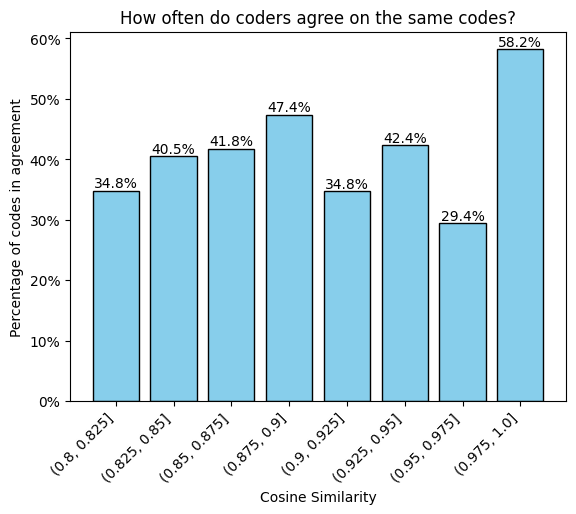

In [219]:
# Define the bins for column A
plot_df = cosine_sim_df.copy()

bins = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0]

# Create a new column 'Bin' which indicates the bin that each value in column A falls into
plot_df['Bin'] = pd.cut(plot_df['cosine_similarity'], bins)

# Calculate the percentage of True values in each bin
bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100

# Create a bar plot
bars = plt.bar(bin_percentages.index.astype(str), bin_percentages, color='skyblue', edgecolor='black')

# Add percentage labels above the bars
for bar, percentage in zip(bars, bin_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Percentage of codes in agreement')
plt.title('How often do coders agree on the same codes?')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# Add '%' sign to the y-axis labels
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.show()

In [220]:
plot_df = cosine_sim_df.copy()
plot_df = plot_df[cosine_sim_df["manifesto_id_x"] != cosine_sim_df["manifesto_id_y"]]

(126190, 24)


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12992\2374201835.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12992\2374201835.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


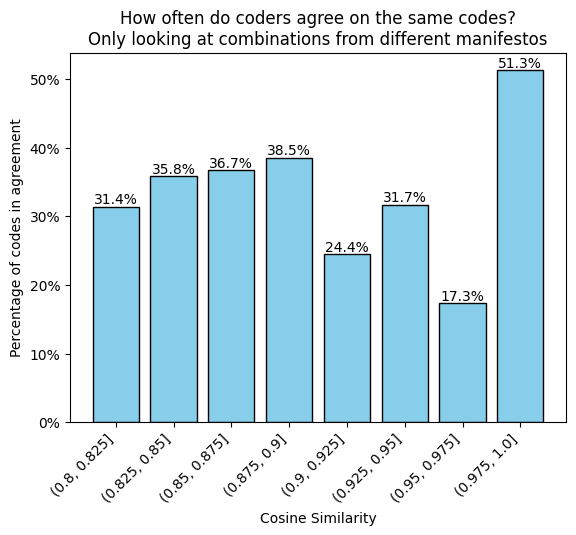

In [221]:
# How does this change if we only take combinations of different documents?
# (So coders dont just pick the same code for the sentence they see again and again?)

# Define the bins for column A
plot_df = cosine_sim_df.copy()
# remove combinations from the same document:
plot_df = plot_df[cosine_sim_df["manifesto_id_x"] != cosine_sim_df["manifesto_id_y"]]
print(plot_df.shape)

bins = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0]

# Create a new column 'Bin' which indicates the bin that each value in column A falls into
plot_df['Bin'] = pd.cut(plot_df['cosine_similarity'], bins)

# Calculate the percentage of True values in each bin
bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100

# Create a bar plot
bars = plt.bar(bin_percentages.index.astype(str), bin_percentages, color='skyblue', edgecolor='black')

# Add percentage labels above the bars
for bar, percentage in zip(bars, bin_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Percentage of codes in agreement')
plt.title('How often do coders agree on the same codes?\nOnly looking at combinations from different manifestos')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# Add '%' sign to the y-axis labels
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.show()

Which codes appear most often? Which most often in agreement? Which most often when not in agreement?

In [231]:
codes = np.union1d(cosine_sim_df["main_codes_x"].unique(), cosine_sim_df["main_codes_y"].unique())

In [249]:
total_counts = dict()
agreement_counts = dict()
disagreement_counts = dict()
for c in codes:
    count = ((cosine_sim_df['main_codes_x'] == c) | (cosine_sim_df['main_codes_y'] == c)).sum()
    total_counts[c] = count
    
    count = ((cosine_sim_df['main_codes_x'] == c) & (cosine_sim_df['main_codes_y'] == c)).sum()
    agreement_counts[c] = count

    count = ((cosine_sim_df['main_codes_x'] != c) ^ (cosine_sim_df['main_codes_y'] != c)).sum()
    disagreement_counts[c] = count


In [258]:
# Create a dictionary with the percentage of disagreement for this code
# so disagreement_count/total_count

perc_dict = dict()
for k,v in total_counts.items():
    perc_dict[k] = disagreement_counts[k]/v

In [275]:
# Getting the dicts into a df:

merged_df = pd.merge(pd.DataFrame(list(total_counts.items()), columns=['code', 'total_counts']),
                     pd.DataFrame(list(perc_dict.items()), columns=['code', 'perc_disagree']),
                     on='code')

merged_df_temp = pd.merge(pd.DataFrame(list(agreement_counts.items()), columns=['code', 'agreement_counts']),
                     pd.DataFrame(list(disagreement_counts.items()), columns=['code', 'disagreement_counts']),
                     on='code')

code_combinations_df = pd.merge(merged_df, merged_df_temp, on='code')

# add the percentage how often a code appears in the similar sentence combinations:
code_combinations_df["perc_total_occurance"] = code_combinations_df["total_counts"]/cosine_sim_df.shape[0]

code_combinations_df.head(3)

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,perc_total_occurance
0,-1,47184,1.000000,0,47184,0.291482
1,0,45827,1.000000,0,45827,0.283099
2,101,748,0.763369,177,571,0.004621


Deeper look into sentences that are exactly the same:

In [280]:
same_df = cosine_sim_df[cosine_sim_df["cosine_similarity"] > 0.9999]
same_df.shape

(42308, 24)

In [284]:
same_df[["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y", "cosine_similarity"]].sort_values(by="cosine_similarity", ascending=True)

,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,cosine_similarity
282700,By 2020-21 we will have restored Defence investment to 2 per cent of GDP.,104,By 2020-21 we will have restored Defence investment to 2 per cent of GDP.,104,1.0
88044,Terrorism,-1,Terrorism,0,1.0
217705,"A Shorten Labor Government will renew investment in Australian multiculturalism, with $28.3 million of new funding to support social cohesion and economic inclusion.",0,"A Shorten Labor Government will renew investment in Australian multiculturalism, with $28.3 million of new funding to support social cohesion and economic inclusion.",607,1.0
322385,• $30.4 million of P was seized in 2010.,605,• $30.4 million of P was seized in 2010.,605,1.0
262805,Central Queensland cannot afford Labor governments at both the federal and state levels.,305,Central Queensland cannot afford Labor governments at both the federal and state levels.,305,1.0
...,...,...,...,...,...
293814,and improved safety features and standards.,501,and improved safety features and standards.,501,1.0
293813,and improved safety features and standards.,501,and improved safety features and standards.,501,1.0
286212,"To ensure all Australians have the skills they need for work, the Government will provide $62.4 million to establish a national program to deliver foundational skills training.",411,"To ensure all Australians have the skills they need for work, the Government will provide $62.4 million to establish a national program to deliver foundational skills training.",411,1.0
232617,"The Coalition Government is supporting apprentices through Trade Support Loans – helping apprentices with the costs of living, tools and training through loans of up to $20,000 each.",411,"The Coalition Government is supporting apprentices through Trade Support Loans – helping apprentices with the costs of living, tools and training through loans of up to $20,000 each.",411,1.0
